<a href="https://colab.research.google.com/github/NAVEED261/MY-AI-ASSISTANT/blob/main/Part_5_Manually_Updating_the_State_to_human_in_the_loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai tavily-python langchain_community


# In the previous section,
 we showed how to interrupt a graph so that a human could inspect its actions. This lets the human read the state, but if they want to change their agent's course, they'll need to have write access.

Thankfully, LangGraph lets you manually update state! Updating the state lets you control the agent's trajectory by modifying its actions (even modifying the past!). This capability is particularly useful when you want to correct the agent's mistakes, explore alternative paths, or guide the agent towards a specific goal.

We'll show how to update a checkpointed state below. As before, first, define your graph. We'll reuse the exact same graph as before.

In [120]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "quickstart"

gemini_api_key = userdata.get('my_stenographer_key')
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

In [121]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults # Import the necessary class
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=gemini_api_key
)

llm.invoke("greet me")

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("what is current weather in karachi")

[{'url': 'https://www.weatherapi.com/',
  'content': "{'location': {'name': 'Karachi', 'region': 'Sindh', 'country': 'Pakistan', 'lat': 24.8667, 'lon': 67.05, 'tz_id': 'Asia/Karachi', 'localtime_epoch': 1731052255, 'localtime': '2024-11-08 12:50'}, 'current': {'last_updated_epoch': 1731051900, 'last_updated': '2024-11-08 12:45', 'temp_c': 30.2, 'temp_f': 86.3, 'is_day': 1, 'condition': {'text': 'Sunny', 'icon': '//cdn.weatherapi.com/weather/64x64/day/113.png', 'code': 1000}, 'wind_mph': 11.4, 'wind_kph': 18.4, 'wind_degree': 248, 'wind_dir': 'WSW', 'pressure_mb': 1013.0, 'pressure_in': 29.92, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 64, 'cloud': 0, 'feelslike_c': 34.2, 'feelslike_f': 93.5, 'windchill_c': 30.2, 'windchill_f': 86.3, 'heatindex_c': 34.2, 'heatindex_f': 93.5, 'dewpoint_c': 22.6, 'dewpoint_f': 72.6, 'vis_km': 10.0, 'vis_miles': 6.0, 'uv': 6.0, 'gust_mph': 13.1, 'gust_kph': 21.1}}"},
 {'url': 'https://world-weather.info/forecast/pakistan/karachi/august-2024/',
  'cont

In [125]:
from typing import Annotated


from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import AIMessage, ToolMessage
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)



llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
# jo list function ma ho wo is tool node ma bna k tools m apass krdo
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt **after** actions, if desired.
    # interrupt_after=["tools"]
)



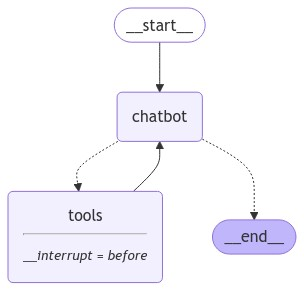

In [126]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [127]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [128]:
snapshot = graph.get_state(config)
snapshot.next


('tools',)

In [129]:
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (c357dcc9-3367-47a9-8462-4a2f1a3e6a69)
 Call ID: c357dcc9-3367-47a9-8462-4a2f1a3e6a69
  Args:
    query: LangGraph


# so far,
 "Yeh tamam pehla section ka bilkul waise hi repeat hai. LLM ne bas search engine tool use karne ki request ki thi aur hamara graph interrupt ho gaya. Agar hum pehle ki tarah aage barhte hain, toh tool ko web search ke liye call kiya jayega. Lekin agar user beech mein hi hissa lena chahein? Ya agar humein lage ke chat bot ko tool ka istemal zaroori nahi?"

In [130]:
answer = (
    "fatima and umaima are both my kids."
)
new_messages = [
    # The LLM API expects some ToolMessage to match its tool call. We'll satisfy that here.
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    # And then directly "put words in the LLM's mouth" by populating its response.
    AIMessage(content=answer),
]
# llm or tool msg na manually answer pas kya

new_messages[-1].pretty_print()
# ai msg jo similer tool ka answer wo read able bnaya
graph.update_state(
    # Which state to update
    config,
    # The updated values to provide. The messages in our `State` are "append-only", meaning this will be appended
    # to the existing state. We will review how to update existing messages in the next section!
    {"messages": new_messages},
)
# porana msg ko new sa update kya
# print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])
# last two msg jo tool or ai k tha wo read kya
# conclusion : yha hmna state ko update krdya ha

================================== Ai Message ==================================

fatima and umaima are both my kids.
[ToolMessage(content='fatima and umaima are both my kids.', id='6fa76e52-29c8-4c3a-af37-7d6699f04bd6', tool_call_id='c357dcc9-3367-47a9-8462-4a2f1a3e6a69'), AIMessage(content='fatima and umaima are both my kids.', additional_kwargs={}, response_metadata={}, id='d1097366-ba99-4a70-9138-3951756214da')]


In [131]:
graph.update_state(
    config,
    {"messages": [AIMessage(content="I'm an AI expert!")]},
    # Yeh function kis node ke tor par act karega. Yeh automatically processing ko aise continue karega jaise ye node abhi run hui ho."
    as_node="chatbot",
)
# update krna k lya hama jis node sa start krna ha uska function bnaya or wo node chatbot ha

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef9da75-9801-611d-8003-0693a5045dd5'}}

In [132]:
snapshot = graph.get_state(config)
print(snapshot.values["messages"][-3:])
print(snapshot.next)
# kon sa work flow abhi chlrha ha or aaga konsa node ya tool ha or last k 3 msg read kya

[ToolMessage(content='fatima and umaima are both my kids.', id='6fa76e52-29c8-4c3a-af37-7d6699f04bd6', tool_call_id='c357dcc9-3367-47a9-8462-4a2f1a3e6a69'), AIMessage(content='fatima and umaima are both my kids.', additional_kwargs={}, response_metadata={}, id='d1097366-ba99-4a70-9138-3951756214da'), AIMessage(content="I'm an AI expert!", additional_kwargs={}, response_metadata={}, id='25f3e106-e6a5-47af-b215-9cbe4683dfda')]
()


In [133]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "2"}}  # we'll use thread_id = 2 here
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()
        # update wala msg dya

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (7a86a434-5378-4f79-badf-2c9fb873d0d7)
 Call ID: 7a86a434-5378-4f79-badf-2c9fb873d0d7
  Args:
    query: LangGraph


In [134]:
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
print("Original")
print("Message ID", existing_message.id)
print(existing_message.tool_calls[0])
new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "LangGraph human-in-the-loop workflow"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state rather than APPEND this messages
    id=existing_message.id,
)

print("Updated")
print(new_message.tool_calls[0])
print("Message ID", new_message.id)
graph.update_state(config, {"messages": [new_message]})

print("\n\nTool calls")
graph.get_state(config).values["messages"][-1].tool_calls
# is ko completely update kya

Original
Message ID run-8d899202-c31c-46a4-a112-c5c440a8e0c7-0
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': '7a86a434-5378-4f79-badf-2c9fb873d0d7', 'type': 'tool_call'}
Updated
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph human-in-the-loop workflow'}, 'id': '7a86a434-5378-4f79-badf-2c9fb873d0d7', 'type': 'tool_call'}
Message ID run-8d899202-c31c-46a4-a112-c5c440a8e0c7-0


Tool calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph human-in-the-loop workflow'},
  'id': '7a86a434-5378-4f79-badf-2c9fb873d0d7',
  'type': 'tool_call'}]

In [135]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()
        # status chk kya update k bad ka

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (7a86a434-5378-4f79-badf-2c9fb873d0d7)
 Call ID: 7a86a434-5378-4f79-badf-2c9fb873d0d7
  Args:
    query: LangGraph human-in-the-loop workflow
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.youtube.com/watch?v=9BPCV5TYPmg", "content": "In this video, I'll show you how to handle persistence with LangGraph, enabling a unique Human-in-the-Loop workflow. This approach allows a human to grant an"}, {"url": "https://medium.com/@kbdhunga/implementing-human-in-the-loop-with-langgraph-ccfde023385c", "content": "Implementing a Human-in-the-Loop (HIL) framework in LangGraph with the Streamlit app provides a robust mechanism for user engagement and decision-making. By incorporating breakpoints and"}]
================================== Ai Message ==================================

LangGraph

In [119]:
events = graph.stream(
    {
        "messages": (
            "user",
            "Remember what I'm learning about?",
        )
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

        # remember kerwana k lya dobara yhi input lya asa a question

================================ Human Message =================================

Remember what I'm learning about?
================================== Ai Message ==================================

You are learning about LangGraph, a graph database designed for large language models.
